In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))


In [2]:
gwas_covar_f <- '@@@@@@@@@@@@@@@@@@@'


In [3]:
gwas_covar_df <- fread(
    gwas_covar_f,
    select=c('FID', 'IID', 'population', 'split', 'age', 'sex', 'N_CNV', 'LEN_CNV', 'Array', paste0('PC', 1:10)),
    colClasses=c('FID'='character', 'IID'='character')
)


In [4]:
FIDs <- gwas_covar_df %>%
filter(split == 'val') %>%
pull(FID)

In [5]:
traits <- c(
    'INI30190',
    'INI30150',
    'INI30210',
    'INI30120',
    'INI30180',
    'INI30140',
    'INI30200',
    'INI30000'
)


In [6]:
score_df <- traits %>% lapply(function(trait){
    score_f <- sprintf('data/%s/%s.sscore.zst', trait, trait)

    score_df <- fread(
        cmd=paste('zstdcat', score_f),
        select=c('#FID', 'IID', 'SCORE1_SUM'),
        colClasses=c('#FID'='character', 'IID'='character')
    ) %>%
    rename('FID'='#FID') %>%
    rename(!!trait := 'SCORE1_SUM')    
}) %>%
reduce(function(x, y){x %>% inner_join(y, by=c('FID', 'IID'))})


In [7]:
score_df_val <- score_df %>%
filter(FID %in% FIDs)


In [11]:
p <- score_df_val %>%
select(-FID) %>%
gather(trait, PRS, -IID) %>%
ggplot(aes(x=PRS))+
geom_histogram(bins=30) + 
facet_wrap( ~ trait, ncol=3, scales="free_x") + 
theme_bw()+
labs(
    title = 'PRS distribution in the validation set',
    x = 'snpnet PRS',
    y = 'number of individuals'
)


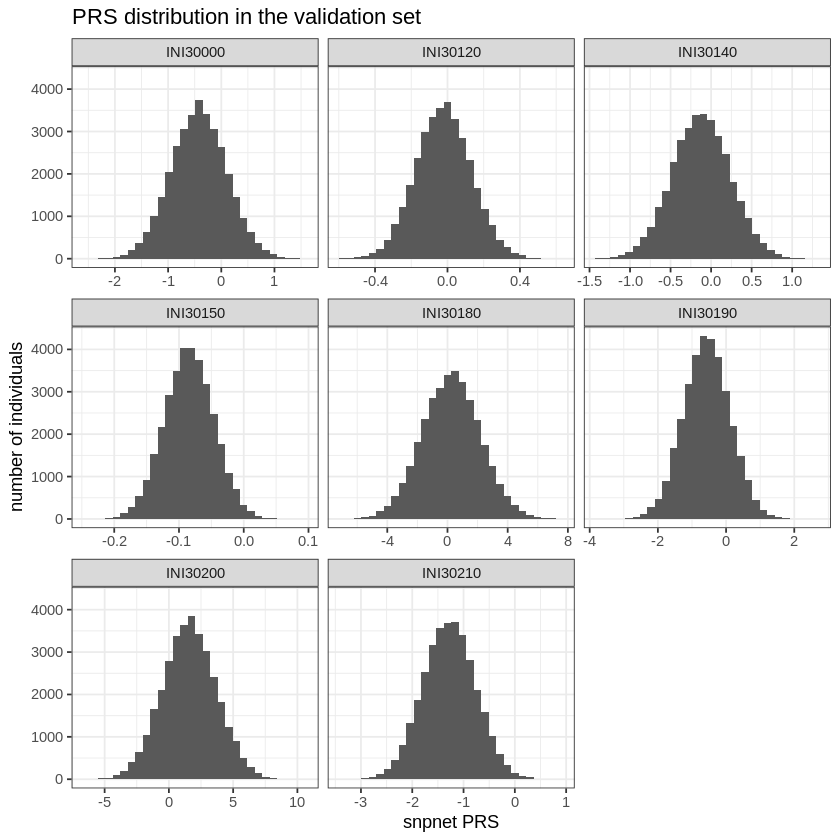

In [12]:
p

In [13]:
ggsave('PRS.dist.png', p)

Saving 6.67 x 6.67 in image


In [8]:
sd_df <- setNames(
    traits %>%
    lapply(function(t){sd(score_df_val[[t]])}), 
    traits
) %>%
as.data.frame()
rownames(sd_df) <- 'sd'


In [9]:
summary_df <- traits %>%
lapply(function(t){
    df <- data.frame(
        unclass(summary(score_df_val[[t]])), 
        check.names = FALSE, 
        stringsAsFactors = FALSE
    )
    names(df)<-t
    df
}) %>%
bind_cols()
rownames(summary_df)<- names(summary(1:3))


In [10]:
summary_df2 <- bind_rows(
    summary_df %>% rownames_to_column('statistic'),
    sd_df %>% rownames_to_column('statistic')    
)


In [15]:
summary_df2 %>%
rename('#statistic' = 'statistic') %>%
fwrite('PRS.dist.statistic.tsv', sep='\t', na = "NA", quote=F)
